<a href="https://colab.research.google.com/github/Ingasha-Sharon/DaskNotebook/blob/main/DaskNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'divvy-tripdata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5070262%2F8497103%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T215427Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a30f4f6a3d486d710f6072a546093442cb84f1e7b2192fe09e54d6ec8b5869823ef1d3728d4826f056e8cd9c6d82371f443b7eb5ddd0bfb66e0ff92fb98cacc955afb49b85ee463698989305f471304c538bcdc9e43b46d0e881b2d2f0c87fa59395119e966b31344a46ded69f0748b54e3ab0f9036ffc527f218267b077b287872131c87cca09155a45074760afabdd8718d09f527a82a96e80b11acfe811956f586c27d632f071b395593881d5ac76be7f9c693acb79ec0db494fd32c71793eee8d97bb27906fb4271ee63bfd01467683851dad297441b1d94438be76c7ab7a9dec752df089d71bb5b49f35db71c55968baff66e197fd31033a1ed0b99d0a,city-of-chicago-community-boundaries-geojson:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5141614%2F8594842%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T215427Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D979d5408ea80f4488aaa5b76f299f63713b466a6a539eceec0b1fa7fda8890b77ab470c04f50b25f8ddcf8e704db59483a89824b8b6b5baa7596ddacbce442842f12fab7100813b9e6c686014dbadaacaa21b1b0d7c3b8a4333e85f3a1e157a090a61ad18e9d4aeb457ed05fc1053c54555e3efceaa875ec3c2c0005336501bcedb675f8a8f0c4d7748c7de8f11faeff91306d9a26079489be22ab27e1436f2f602355ec2223e1bcf320eeeb26927ee69db1b97ba706047c81c762adfbe56348b90e6d5609a523be4fa640f99d9375cdbbccdab5ae2741368197eac9f5f987d74c7bb51d0e18b5b4baa100ebdedd2c4e4a44878e76632e4b214f7f3bfe1fabe4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 15648650 bytes downloaded
Downloaded and uncompressed: divvy-tripdata
[==================================================] 745871 bytes downloaded
Downloaded and uncompressed: city-of-chicago-community-boundaries-geojson
Data source import complete.


In [ ]:
!pip install --upgrade pyogrio PyGEOS shapely dask dask-geopandas &> ./install.log && echo "Done."

Done.


In [ ]:
import dask.dataframe as dd
import geopandas as gd
from dask import delayed
from dask.diagnostics import ProgressBar

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-3-33037e3bbd21>:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling Py

In [ ]:
# check divvy bikes trip data
ddf = dd.read_csv(
    "/kaggle/input/divvy-tripdata/202404-divvy-tripdata.csv",
    parse_dates = [
        'started_at',
        'ended_at',
    ]
)

In [ ]:
# check city of chicago boundaries data

# geopandas
gf = gd.read_file(
    "/kaggle/input/city-of-chicago-community-boundaries-geojson/chicago_community_boundaries.json",
    geometry = 'geometry',
    crs = 'EPSG:4326',
)

In [ ]:
# dask geopandas
gddf = gd.read_file(
    "/kaggle/input/city-of-chicago-community-boundaries-geojson/chicago_community_boundaries.json",
    # Series that contains the geometry
    geometry = 'geometry',
    # CRS
    crs = "EPSG:4326",
)

In [ ]:
# # round coordinates to fifth decimal places, 1.1 meters at sea level
# def trim_coordinates(df):
#     for col in ['start_lng', 'start_lat', 'end_lng', 'end_lat']:
#         df[col] = df[col].apply(lambda x: round(x, 5))
#     return df

# # create the task
# ddf = ddf.map_partitions(trim_coordinates)

In [ ]:
ddf.head(1)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,743252713F32516B,classic_bike,2024-04-22 19:08:21,2024-04-22 19:12:56,Aberdeen St & Jackson Blvd,13157,Desplaines St & Jackson Blvd,15539,41.877726,-87.654787,41.878119,-87.643948,member


In [ ]:
# show Series labels and total missing values for each Series
ddf.isna().sum().to_frame(name = "Missing Values").compute().transpose()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
Missing Values,0,0,0,0,74793,74793,78519,78519,0,0,479,479,0


In [ ]:
# categorical data
ddf = ddf.categorize([
    'rideable_type',
    'start_station_name',
    'end_station_name',
    'member_casual',
])

In [ ]:
# duration of trip
ddf['duration'] = ddf['ended_at'] - ddf['started_at']

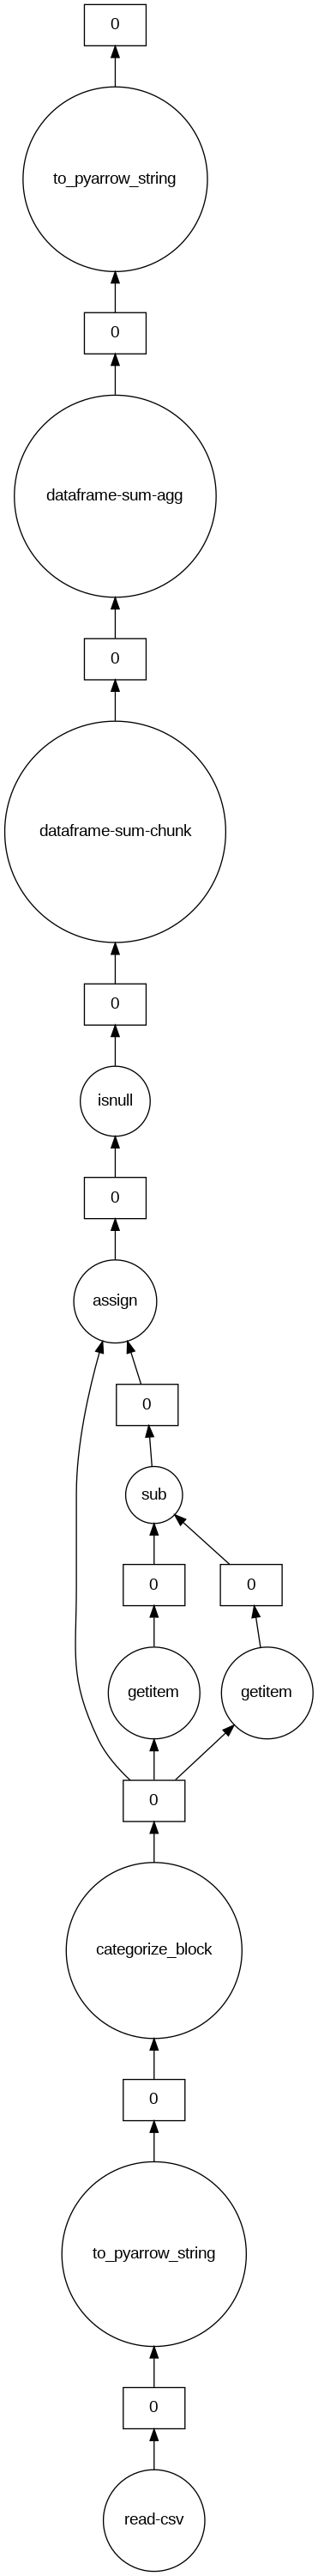

In [ ]:
# describe a summation of null values
ddf.isnull().sum().visualize()

# the graphs can become dense in short order.

In [ ]:
# round the float64 Series to 5 decimal places
for column in ddf.columns:
    if ddf[column].dtype in ['float64']:
        ddf[column] = ddf[column].round(5)

In [ ]:
ddf_start_minmax = ddf.compute().dropna(subset=['start_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng'])

#Calculate the min and max values for each group
display(
    ddf_start_minmax.groupby('start_station_name').agg({
        'start_lat': ['min', 'max'],
        'start_lng': ['min', 'max'],
        'end_lat': ['min', 'max'],
        'end_lng': ['min', 'max']
    })
)

start_lat           start_lng            \
                                   min       max       min       max   
start_station_name                                                     
2112 W Peterson Ave           41.99107  41.99124 -87.68372 -87.68356   
21st St & Pulaski Rd          41.85344  41.85349 -87.72487 -87.72443   
63rd St Beach                 41.78091  41.78100 -87.57634 -87.57625   
900 W Harrison St             41.86486  41.88157 -87.66531 -87.64708   
Aberdeen St & Jackson Blvd    41.87612  41.87799 -87.65509 -87.65405   
...                                ...       ...       ...       ...   
Woodlawn Ave & 58th St        41.78931  41.78962 -87.59668 -87.59630   
Woodlawn Ave & 75th St        41.75916  41.75920 -87.59579 -87.59575   
Woodlawn Ave & Lake Park Ave  41.81398  41.81417 -87.59705 -87.59697   
Yates Blvd & 75th St          41.75876  41.75877 -87.56644 -87.56640   
Yates Blvd & 93rd St          41.72617  41.72617 -87.56628 -87.56628   

                               end_lat             end_lng            
                                   min       max       min       max  
start_station_name                                                    
2112 W Peterson Ave           41.93000  42.01920 -87.71000 -87.63643  
21st St & Pulaski Rd          41.81628  41.87000 -87.73444 -87.68000  
63rd St Beach                 41.75787  41.89000 -87.63000 -87.54939  
900 W Harrison St             41.83820  41.95424 -87.72609 -87.60727  
Aberdeen St & Jackson Blvd    41.82361  41.94023 -87.72357 -87.61204  
...                                ...       ...       ...       ...  
Woodlawn Ave & 58th St        41.75712  41.94947 -87.64645 -87.57584  
Woodlawn Ave & 75th St        41.74344  41.78788 -87.63121 -87.57632  
Woodlawn Ave & Lake Park Ave  41.73648  41.97803 -87.67030 -87.56751  
Yates Blvd & 75th St          41.75117  41.76641 -87.59575 -87.56569  
Yates Blvd & 93rd St          41.78510  41.78510 -87.60107 -87.60107  

[1208 rows x 8 columns]

In [ ]:
ddf.groupby(
    'start_station_name',
    observed = True,
).mean(
    numeric_only = True
).head(3)

,start_lat,start_lng,end_lat,end_lng
start_station_name,,,,
2112 W Peterson Ave,41.991179,-87.683611,41.983100,-87.673726
21st St & Pulaski Rd,41.853460,-87.724542,41.841757,-87.718812
63rd St Beach,41.780912,-87.576319,41.793908,-87.584819


In [ ]:
# usage by rideable type and member type
display(
    ddf.pivot_table(
        index = 'rideable_type',
        columns = 'member_casual',
        values = 'duration',
        aggfunc = 'sum',
    ).compute()
)

member_casual,casual,member
rideable_type,,
classic_bike,1641 days 23:42:50,1331 days 10:44:34
electric_bike,738 days 00:53:31,1098 days 12:51:19


In [ ]:
display(
    ddf.pivot_table(
        index = 'end_station_name',
        columns = 'member_casual',
        values = 'rideable_type',
        aggfunc = 'count',
    ).compute()
)

member_casual,casual,member
end_station_name,,
2112 W Peterson Ave,21.0,35.0
21st St & Pulaski Rd,1.0,0.0
63rd St Beach,62.0,37.0
900 W Harrison St,222.0,823.0
Aberdeen St & Jackson Blvd,201.0,799.0
...,...,...
Woodlawn Ave & 58th St,188.0,671.0
Woodlawn Ave & 75th St,7.0,5.0
Woodlawn Ave & Lake Park Ave,37.0,59.0


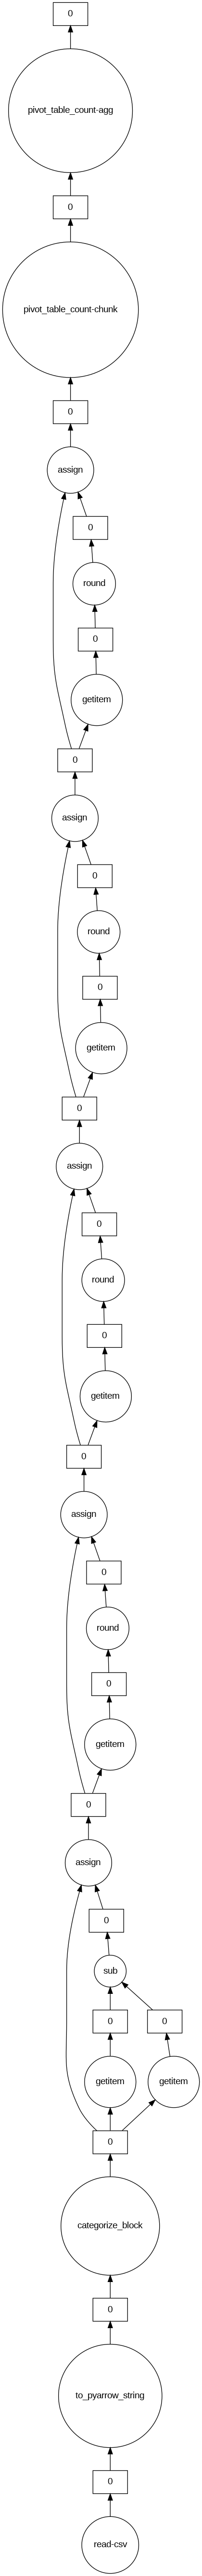

In [ ]:
ddf.pivot_table(
    index = 'start_station_name',
    columns = 'member_casual',
    values = 'rideable_type',
    aggfunc = 'count',
).visualize()

In [ ]:
ddf.pivot_table(
    index = 'rideable_type',
    columns = 'member_casual',
    values = 'start_station_name',
    # mean sum count for dask pivot_table
    aggfunc = 'count',
).compute()

member_casual,casual,member
rideable_type,,
classic_bike,57819.0,130584.0
electric_bike,50409.0,101420.0


In [ ]:
# dask delayed decorator
import dask

@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x * 2

@dask.delayed
def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

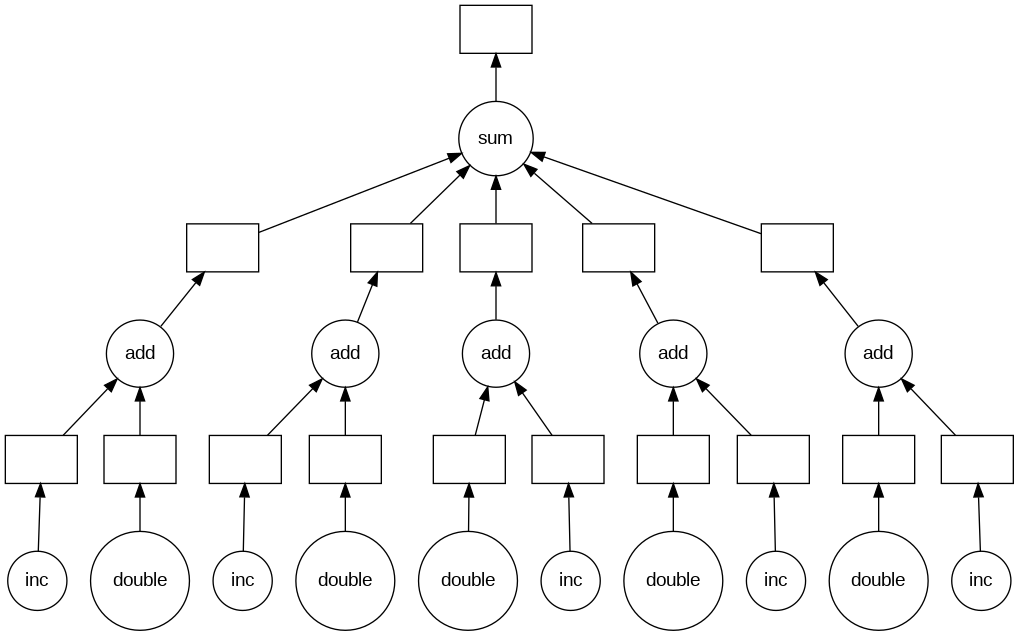

In [ ]:
total.visualize()